In [341]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

from nltk.corpus import stopwords

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import string 


from spacy.lang.en.stop_words import STOP_WORDS

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vlad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
train_df = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'sentiment'])
test_df = pd.read_csv('products_sentiment_test.tsv', sep='\t', usecols=[1])

### Train DF

In [3]:
train_df.head()

,text,sentiment
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [4]:
print('Train Size: ', train_df.shape[0])

Train Size:  2000


### Test DF

In [5]:
test_df.head()

,text
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [6]:
print('Test Size: ', test_df.shape[0])

Test Size:  500


### Baseline 

In [333]:
# Train Data
X_train = train_df['text']
y_train = train_df['sentiment']

# Test Data
X_test = test_df['text']

In [8]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(X_train)

print('N Features: ', len(count_vectorizer.get_feature_names()))

N Features:  3973


In [9]:
pipeline = Pipeline([
    ('feat_gen', CountVectorizer()),
    ('model', LogisticRegression())
])

cv_results = cross_val_score(pipeline, X=X_train, y=y_train, n_jobs=-1, scoring='accuracy', error_score='raise')
print('Accuracy CV: ', np.mean(cv_results))

Accuracy CV:  0.7685


In [10]:
def make_submission(data, f_name):
    submission = pd.DataFrame(data, columns=['y']).reset_index().rename(columns={'index': 'Id'})
    submission.to_csv(f_name, index=False)   
    

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

make_submission(preds, 'base_line.csv')

**Kaggle Score(Test: `0.77555`)**

### Baseline Improvement_1

In [11]:
# Some negations aren't correct
X_train = X_train.apply(lambda text: text.replace("n't", 'not').replace("n 't", " not"))

In [12]:
def make_pipe(vectorizer, transformer, model):
    return Pipeline([
        ('vectorizer', vectorizer),
        ('transformer', transformer),
        ('classifier', model)
    ])

In [13]:
# Find the best combination 
vectorizers = [CountVectorizer(), TfidfVectorizer()]
transformers = [TruncatedSVD(), TfidfTransformer()]
models = [LogisticRegression(), LinearSVC(), SGDClassifier()]

for model in models:
    for vectorizer in vectorizers:
        for transformer in transformers:
            print(str(model) + '---' + str(vectorizer) + '---' + str(transformer))
            cv_results = cross_val_score(
                make_pipe(vectorizer, transformer, model),
                X=X_train,
                y=y_train,
                cv=5,
                n_jobs=-1
            ).mean()
            print('Accuracy CV: ', cv_results)

LogisticRegression()---CountVectorizer()---TruncatedSVD()
Accuracy CV:  0.6369999999999999
LogisticRegression()---CountVectorizer()---TfidfTransformer()
Accuracy CV:  0.7685
LogisticRegression()---TfidfVectorizer()---TruncatedSVD()
Accuracy CV:  0.638
LogisticRegression()---TfidfVectorizer()---TfidfTransformer()
Accuracy CV:  0.7595000000000001
LinearSVC()---CountVectorizer()---TruncatedSVD()
Accuracy CV:  0.6369999999999999
LinearSVC()---CountVectorizer()---TfidfTransformer()
Accuracy CV:  0.769
LinearSVC()---TfidfVectorizer()---TruncatedSVD()
Accuracy CV:  0.6425
LinearSVC()---TfidfVectorizer()---TfidfTransformer()
Accuracy CV:  0.7625
SGDClassifier()---CountVectorizer()---TruncatedSVD()
Accuracy CV:  0.5645
SGDClassifier()---CountVectorizer()---TfidfTransformer()
Accuracy CV:  0.7575
SGDClassifier()---TfidfVectorizer()---TruncatedSVD()
Accuracy CV:  0.6369999999999999
SGDClassifier()---TfidfVectorizer()---TfidfTransformer()
Accuracy CV:  0.7515000000000001


Select `LinearSVC---CountVectorizer---TfidfTransformer`

In [14]:
main_pipeline = make_pipe(vectorizer=CountVectorizer(),
                          transformer=TfidfTransformer(),
                          model=LinearSVC())

cv_results = cross_val_score(pipeline, X=X_train, y=y_train, n_jobs=-1, scoring='accuracy', error_score='raise')
print('Accuracy CV: ', np.mean(cv_results))

Accuracy CV:  0.772


In [15]:
# Test 
main_pipeline.fit(X_train, y_train)
preds = main_pipeline.predict(X_test)

make_submission(preds, 'base_line_2.csv')

**Kaggle Score(Test: `0.77777`)**

### Baseline Improvement_3
- Function `clean_text()`
- Lemmantization, Stemming (`lem_stem_text()`) : leads to metric on CV Try on kaggle!!
- Custom Stop words (works better)

In [16]:
# Stemming and Lemmantization (Example)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Let's test on the first sentence 
sample = X_train[0].split(' ')
sample

['2', '.', 'take', 'around', '10,000', '640x480', 'pictures', '.']

In [17]:
# lemmatization
init_forms = [lemmatizer.lemmatize(word) for word in sample]
init_forms

['2', '.', 'take', 'around', '10,000', '640x480', 'picture', '.']

In [18]:
# Stemming 
singles = [stemmer.stem(word) for word in sample]
singles

['2', '.', 'take', 'around', '10,000', '640x480', 'pictur', '.']

In [342]:
def lem_stem_text(text):
    init_forms = [lemmatizer.lemmatize(word) for word in text.split(' ')] # lemmatization
    stem_text = [stemmer.stem(word) for word in init_forms] # stemming 
    return ' '.join(init_forms)

In [331]:
def clean_text(text):
    
    """
    Order is important!!!
    
    """
    # Handel numbers 
    clean_text = re.sub(r'\d+x\d+', '', text) # remove resolution
    clean_text = re.sub(r'\d+', '', clean_text) #  remove numbers
    
    # Hande auxiliary
   
    clean_text = clean_text.replace("can 't", "cannot")
    clean_text = clean_text.replace("wouldnt", "would not").replace("wouldn 't", "would not").replace("wouldn't", "would not")
    
    clean_text = clean_text.replace("wont", "will not").replace("won 't", "will not").replace("won't", "will not")
    clean_text = clean_text.replace("dont", "do not").replace("don 't", "do not").replace("don't", "do not")
    clean_text = clean_text.replace("doesnt", "does not").replace("doesn 't", "does not").replace("doesn't", "does not")
    clean_text = clean_text.replace("didnt", "did not").replace("didn 't", "did not").replace("didn't", "did not")
        
    # Handle negations
    clean_text = clean_text.replace("n't", "not")

    # Hande punctuation
    clean_text = ''.join([char for char in clean_text if char not in string.punctuation])
    
    # Handle whitespaces
    clean_text = re.sub('\s+', ' ', clean_text).strip()
    
    return clean_text

In [337]:
words_to_leave = {"not", "however", "never", "but", "neither", "none", "nowhere", "although", "though"}

# New stop words
res_stop_words = STOP_WORDS.difference(words_to_leave)

In [327]:
# Train Data
X_train = train_df['text']
y_train = train_df['sentiment']

**Look at features with preprocessing and without**

In [271]:
# Clean X_train
X_train_clean = X_train.apply(clean_text)

count_vectorizer = CountVectorizer(stop_words=res_stop_words)

count_vectorizer.fit_transform(X_train_clean)

print('N Features: ', len(count_vectorizer.get_feature_names()))
count_vectorizer.get_feature_names()


N Features:  3667


['abandoned',
 'abilities',
 'ability',
 'abit',
 'able',
 'aboveaverage',
 'abovementioned',
 'absolute',
 'absolutely',
 'absolutly',
 'abuse',
 'abusing',
 'ac',
 'academic',
 'acceptable',
 'acceptible',
 'access',
 'accessibility',
 'accessible',
 'accessing',
 'accessories',
 'accessory',
 'accident',
 'accidently',
 'accompanying',
 'accomplishes',
 'accuracy',
 'accurate',
 'accurately',
 'accustomed',
 'achieve',
 'achievement',
 'achilles',
 'acknoledge',
 'acknowledge',
 'acoustic',
 'action',
 'activate',
 'activated',
 'acts',
 'actual',
 'actually',
 'ad',
 'adapter',
 'adaptor',
 'add',
 'added',
 'addict',
 'addition',
 'additional',
 'addon',
 'address',
 'adds',
 'addtl',
 'adequate',
 'adequately',
 'adit',
 'adjust',
 'adjustable',
 'adjustment',
 'adjustments',
 'admit',
 'adore',
 'adustment',
 'advanced',
 'advantage',
 'advantages',
 'advertised',
 'advice',
 'advise',
 'advocate',
 'aesthetic',
 'affect',
 'affordable',
 'africa',
 'age',
 'agents',
 'agian',
 

In [269]:
# Dirty X_train 
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X_train)

print('N Features: ', len(count_vectorizer.get_feature_names()))
count_vectorizer.get_feature_names()

N Features:  3973


['00',
 '000',
 '10',
 '100',
 '1000s',
 '105',
 '11',
 '1100s',
 '11b',
 '12',
 '1200',
 '128',
 '128bps',
 '12x',
 '13',
 '133',
 '135',
 '14',
 '14x',
 '15',
 '150',
 '1500',
 '16',
 '160',
 '160x120',
 '17',
 '18',
 '19gb',
 '19mm',
 '1gb',
 '1st',
 '1x',
 '20',
 '200',
 '2000',
 '2002',
 '2003',
 '2004',
 '202',
 '20gb',
 '20usd',
 '24',
 '25',
 '250',
 '256',
 '26',
 '2600',
 '27',
 '278',
 '28',
 '280',
 '2in',
 '2nd',
 '2x',
 '30',
 '300',
 '30gb',
 '32',
 '32mb',
 '33',
 '3330',
 '35',
 '35mb',
 '35mm',
 '36',
 '360',
 '3660',
 '38',
 '3hp',
 '3rd',
 '3x',
 '3x4cm',
 '40',
 '400',
 '405',
 '40gb',
 '4155',
 '4300',
 '45',
 '4500',
 '48',
 '491',
 '4mp',
 '4x',
 '50',
 '500',
 '512',
 '512mb',
 '54',
 '54g',
 '54mbps',
 '55',
 '57',
 '5717',
 '5g',
 '5gb',
 '60',
 '600',
 '60gb',
 '610',
 '640x480',
 '65',
 '65000',
 '65k',
 '6600',
 '6610',
 '6620',
 '68',
 '70',
 '75',
 '7610',
 '80',
 '800',
 '800mhz',
 '801',
 '8290',
 '850',
 '866',
 '8mb',
 '8x10',
 '90',
 '900',
 '900mhz

`clean_text()` function is must-have because it leads to better and less features

In [338]:
# Pipeline 
clf_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(preprocessor=clean_text, stop_words=res_stop_words,
                                   ngram_range=(1,3), max_df=0.8)), 
    ("transformer", TfidfTransformer(smooth_idf=True, use_idf=True)),
    ("classifier", LinearSVC())
])

cv_results = cross_val_score(clf_pipeline, X=X_train, y=y_train, n_jobs=-1, scoring='accuracy', error_score='raise')
print('Accuracy CV: ', np.mean(cv_results))

Accuracy CV:  0.7565


Though on CV we have less accuray, we have better result on Kaggle

In [ ]:
# Test 
clf_pipeline.fit(X_train, y_train)
preds = clf_pipeline.predict(X_test)

make_submission(preds, 'base_line_3.csv')

**Kaggle Score(Test: `0.78666`)**

In [344]:
# Pipeline 
clf_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(preprocessor=clean_text, stop_words=res_stop_words, analyzer=lem_stem_text,
                                   ngram_range=(1,3), max_df=0.8)), 
    ("transformer", TfidfTransformer(smooth_idf=True, use_idf=True)),
    ("classifier", LinearSVC())
])

cv_results = cross_val_score(clf_pipeline, X=X_train, y=y_train, n_jobs=-1, scoring='accuracy', error_score='raise')
print('Accuracy CV: ', np.mean(cv_results))

Accuracy CV:  0.6435000000000001


In [345]:
# Test 
clf_pipeline.fit(X_train, y_train)
preds = clf_pipeline.predict(X_test)

make_submission(preds, 'base_line_4.csv')

**Kaggle Score(Test: `0.63111`)**

There is slight class imbalance. **We can try balancing classes**

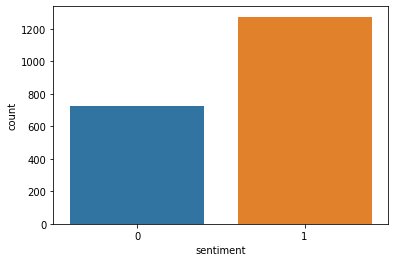

In [347]:
# Classes Balance 
sns.countplot(x=train_df['sentiment']);

In [348]:
train_df['sentiment'].value_counts()/train_df['sentiment'].shape[0]

1    0.637
0    0.363
Name: sentiment, dtype: float64

In [349]:
# Pipeline 
clf_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(preprocessor=clean_text, stop_words=res_stop_words,
                                   ngram_range=(1,3), max_df=0.8)), 
    ("transformer", TfidfTransformer(smooth_idf=True, use_idf=True)),
    ("classifier", LinearSVC())
])


In [350]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)
X = train_df['text'].values.reshape(-1, 1)
X_over, y_over = over_sampler.fit_resample(X, y_train)

cv_results = cross_val_score(clf_pipeline, 
                             X=X_over.reshape(1, X_over.shape[0])[0],
                             y=y_over,
                             cv=5)


print('Accuracy CV: ', np.mean(cv_results))

c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'not', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'not', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'not', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\sklearn\

Accuracy CV:  0.8595307985669709


c:\users\vlad\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'not', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [353]:
clf_pipeline.fit(X_over.reshape(1,X_over.shape[0])[0], y_over)

preds = clf_pipeline.predict(X_test)

make_submission(preds, 'base_line_5.csv')

**Kaggle Score(Test: `0.77555`)**

In [297]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_over.reshape(1, X_over.shape[0])[0],
                                                    y_over,
                                                    test_size=0.2,
                                                    random_state=42)
clf_pipeline.fit(X_train, y_train)

y_pred = clf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       269
           1       0.88      0.84      0.86       241

    accuracy                           0.87       510
   macro avg       0.87      0.87      0.87       510
weighted avg       0.87      0.87      0.87       510



### Inference

In [319]:
clf_pipeline.predict(['I bought a new laptop and it has good quality and quite powerful'])

array([1], dtype=int64)

In [324]:
clf_pipeline.predict(['Bad product!!! Not recommended'])

array([0], dtype=int64)